# Modelo de red neuronal

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Cargar el modelo y el tokenizer de RoBERTuito entrenado para análisis de sentimiento
modelo = "pysentimiento/robertuito-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(modelo)
model = AutoModelForSequenceClassification.from_pretrained(modelo)

# Crear pipeline para clasificación
analizador = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

c:\Users\nerea\anaconda3\envs\sentimentanal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [3]:
# Frase de ejemplo
frase1 = "Estoy harto de todo esto"
frase2 = "Me encanta la programación en Python"
frase3 = "Hoy hace sol"

# Clasificar
resultado = analizador(frase1)
print(resultado)
resultado = analizador(frase2)
print(resultado)
resultado = analizador(frase3)
print(resultado)

[{'label': 'NEG', 'score': 0.9645105600357056}]
[{'label': 'POS', 'score': 0.9567092061042786}]
[{'label': 'NEU', 'score': 0.560903787612915}]


Como se puede apreciar, el modelo de red neuronal da una salida del tipo:
- (sentimiento, score)
donde sentimiento puede ser NEG (negativo), NEU (neutral) o POS (positivo) y score es un número entre 0 y 1, indicando una puntuación asignada por el modelo al sentimiento inferido.

Por tanto, no se trata de un modelo de regresión, o de clasificación binaria, sino de un modelo de clasificación multiclase, donde la salida es la tupla (sentimiento, score).

De cara a poder agregar valores de score, es necesario transformar de acuerdo a nuestro interés. No podemos simplemente sumar los scores, ya que el score por si solo no indica el sentimiento de la frase. En nuestro caso queremos diferenciar entre sentimiento (positivo o negativo) y neutralidad. Por tanto, tiene sentido utilizar el score como un peso y asignar un valor numérico a las etiquetas:

- NEG = 1
- NEU = -1
- POS = 1

Como solo queremos diferenciar entre sentimiento y no sentimiento (para la hipótesis 3), asignamos el valor 1 a NEG y POS, y -1 a NEU. De esta forma, si la frase es positiva o negativa, el score se suma al resultado final, mientras que si es neutral, se resta.

Cada frase quedaría entonces caracterizada por la tupla (sentimiento, score) y una puntuación calculada como:
$$
\text{puntuacion} = \text{sentimiento} \cdot \text{score} 
$$
siendo sentimiento el valor numérico asignado a la etiqueta (-1 o 1).

# Prueba del modelo con datos ficticios

In [4]:
# Generamos un conjunto de datos de ejemplo
import pandas as pd
import numpy as np

lider_a_partido={}
data = pd.read_csv("base_conjunta.csv")
# data["Partido"]


In [5]:
lider_a_partido ={'Santiago Abascal':"VOX", 'Feijóo':"PP", 'Pedro Sánchez':"PSOE", 'PP':"PP", 'PSOE':"PSOE",
       'Sumar':"Sumar", 'Yolanda Díaz':"Sumar", 'VOX':'VOX'}
oposicion = set(['PP', 'VOX', 'Sumar'])
# Añadimos el nombre del partido a cada líder
data["Partido"] = data["nombre"].map(lider_a_partido)
# Añadimos si se trata de oposición
data["Oposicion"] = data["Partido"].apply(lambda x: x in oposicion)
# Filtramos para que solo sea del blackout
data = data[data["blackout"]==1]

In [6]:
data.head()

,nombre,id,timestamp,Lider,body,blackout,origen,Partido,Oposicion
23,Santiago Abascal,1921672524074467407,2025-05-11 23:03:27,si,"Casi hace gracia ver al lehendakari"" del PNV d...",1,ABASCAL,VOX,True
28,Santiago Abascal,1919526266199257304,2025-05-06 00:54:59,si,Y nos dejarán sin aceite… y sin luz. Eso s...,1,ABASCAL,VOX,True
31,Santiago Abascal,1918407566482395148,2025-05-02 22:49:40,si,No estamos obligados a soportar las consecuenc...,1,ABASCAL,VOX,True
36,Santiago Abascal,1917555435680284799,2025-04-30 14:23:36,si,"La responsabilidad directa es del señor"" Pedro...",1,ABASCAL,VOX,True
37,Santiago Abascal,1917473464853610641,2025-04-30 08:57:53,si,El principal responsable es el corrupto Sánche...,1,ABASCAL,VOX,True


In [7]:
from tqdm import tqdm
sentimiento = []
score = []
puntuacion = []
dic = {"NEU":-1, "POS":1, "NEG":1}

for frase in tqdm(data["body"]):
  try:
    resultado = analizador(frase)
  except Exception as e:
    print(f"Error procesando la frase: {frase}")
    print(f"Error: {e}")
  # Guardamos la etiqueta de sentimiento
  sentimiento.append(resultado[0]['label'])
  # guardamos el score
  score.append(resultado[0]['score'])
  
  # calculamos la puntuación multiplicando el score por el valor de la etiqueta
  puntuacion.append(dic[resultado[0]['label']]*resultado[0]['score'])

  
data["Sentimiento"] = sentimiento
data["Score"] = score
data["Puntuacion"] = puntuacion
df = pd.DataFrame(data)

100%|██████████| 89/89 [00:17<00:00,  5.18it/s]


In [ ]:
data.head()

,nombre,id,timestamp,Lider,body,blackout,origen,Partido,Oposicion
23,Santiago Abascal,1921672524074467407,2025-05-11 23:03:27,si,"Casi hace gracia ver al lehendakari"" del PNV d...",1,ABASCAL,VOX,True
28,Santiago Abascal,1919526266199257304,2025-05-06 00:54:59,si,Y nos dejarán sin aceite… y sin luz. Eso s...,1,ABASCAL,VOX,True
31,Santiago Abascal,1918407566482395148,2025-05-02 22:49:40,si,No estamos obligados a soportar las consecuenc...,1,ABASCAL,VOX,True
36,Santiago Abascal,1917555435680284799,2025-04-30 14:23:36,si,"La responsabilidad directa es del señor"" Pedro...",1,ABASCAL,VOX,True
37,Santiago Abascal,1917473464853610641,2025-04-30 08:57:53,si,El principal responsable es el corrupto Sánche...,1,ABASCAL,VOX,True


In [8]:
print("Resultados")
print(df)
print("\n")

# Sumamos puntuacion agrupado por partido
print("Resultados por partido (sumando la puntuacion)")
df_partido = df.groupby("Partido")["Puntuacion"].sum().reset_index()
print(df_partido)
print("\n")
# Sumamos puntuacion agrupado por partido y lider
print("Resultados por partido y lider (sumando la puntuacion)")
df_partido_lider = df.groupby(["Partido", "Lider"])["Puntuacion"].sum().reset_index()
print(df_partido_lider)
print("\n")

Resultados
                nombre                   id            timestamp Lider  \
23    Santiago Abascal  1921672524074467407  2025-05-11 23:03:27    si   
28    Santiago Abascal  1919526266199257304  2025-05-06 00:54:59    si   
31    Santiago Abascal  1918407566482395148  2025-05-02 22:49:40    si   
36    Santiago Abascal  1917555435680284799  2025-04-30 14:23:36    si   
37    Santiago Abascal  1917473464853610641  2025-04-30 08:57:53    si   
...                ...                  ...                  ...   ...   
1070               VOX  1917573720962478185  2025-04-30 15:36:16    no   
1072               VOX  1917541068616225142  2025-04-30 13:26:31    no   
1073               VOX  1917520755404792048  2025-04-30 12:05:48    no   
1080               VOX  1917184132209074472  2025-04-29 13:48:11    no   
1081               VOX  1917152914012786731  2025-04-29 11:44:08    no   

                                                   body  blackout   origen  \
23    Casi hace gracia

Los resultados ficticios nos indican lo siguiente:

- A nivel de partido, todos los valores son positivos, indicando que en general los partidos muestra sentimientos en las frases.
- A nivel de líderes, de nuevo todos los valores son positivos. Destacaríamos que el lider del partido A tiene un score más cercano al 0, lo que indica una carga sentimental más baja que el resto de líderes.

In [9]:
# Confianza de la oposicion que sea negativo
# Tweets negativos de la oposicion
df_oposicion = df[df["Oposicion"] == True]
df_oposicion_neg = df_oposicion[df_oposicion["Sentimiento"] == "NEG"]


confianza = df_oposicion_neg.shape[0] / df_oposicion.shape[0]
print("Confianza de la oposicion que sea negativo: ", confianza)

# Lift
lift = confianza / (df[df["Sentimiento"] == "NEG"].shape[0] / df.shape[0])
print("Tweets negativos de la oposicion")
print(df_oposicion_neg.shape[0])
print("Tweets de la oposicion")
print(df_oposicion.shape[0])
print("Total de tweets negativos")
print(df[df["Sentimiento"] == "NEG"].shape[0])
print("Lift: ", lift)

Confianza de la oposicion que sea negativo:  0.819672131147541
Tweets negativos de la oposicion
50
Tweets de la oposicion
61
Total de tweets negativos
58
Lift:  1.2577727529677785


Hipotesis 3

In [10]:

data_ps = data[data["nombre"]=="Pedro Sánchez"]
data_nf = data[data["nombre"]=="Feijóo"]
data_ab = data[data["nombre"]=="Santiago Abascal"]
data_yd = data[data["nombre"]=="Yolanda Díaz"]
data_su = data[data["nombre"]=="Sumar"]
data_pp = data[data["nombre"]=="PP"]
data_vox = data[data["nombre"]=="VOX"]
data_psoe = data[data["nombre"]=="PSOE"]


Hipótesis de normalidad

In [11]:
from scipy.stats import kstest, ttest_ind, mannwhitneyu

# Aplicar test de normalidad a cada dataset usando {}

# Aplicar test de hipótesis por pares (en Puntuación)
# Usando el modelo {modelo}


# Comprobar normalidad con Kolmogórov-Smirnov
normalidad_pp = kstest(data_pp["Puntuacion"], 'norm')
normalidad_psoe = kstest(data_psoe["Puntuacion"], 'norm')
normalidad_su = kstest(data_su["Puntuacion"], 'norm')
normalidad_vox = kstest(data_vox["Puntuacion"], 'norm')

normalidad_ps = kstest(data_ps["Puntuacion"], 'norm')
normalidad_nf = kstest(data_nf["Puntuacion"], 'norm')
normalidad_ab = kstest(data_ab["Puntuacion"], 'norm')
normalidad_yd = kstest(data_yd["Puntuacion"], 'norm')

print("Normalidad PP:", normalidad_pp.pvalue)
print("Normalidad Feijóo:", normalidad_nf.pvalue)

print("Normalidad PSOE:", normalidad_psoe.pvalue)
print("Normalidad Pedro Sánchez:", normalidad_ps.pvalue)

print("Normalidad Sumar:", normalidad_su.pvalue)
print("Normalidad Yolanda Díaz:", normalidad_yd.pvalue)

print("Normalidad VOX:", normalidad_vox.pvalue)
print("Normalidad Santiago Abascal:", normalidad_ab.pvalue)

Normalidad PP: 1.5322827850713672e-06
Normalidad Feijóo: 0.0010292729741252526
Normalidad PSOE: 0.23144435329093105
Normalidad Pedro Sánchez: 0.5140538127728449
Normalidad Sumar: 0.1312014828191712
Normalidad Yolanda Díaz: 0.37310063530629467
Normalidad VOX: 0.0004161790567379947
Normalidad Santiago Abascal: 6.367621805612019e-07


Hipótesis de medias

In [12]:
# PSOE y PS son normales
t_test_result_psoe = ttest_ind(data_psoe["Puntuacion"], data_ps["Puntuacion"])
print("Medias de puntuación")
print("PSOE:", data_psoe["Puntuacion"].mean())
print("Pedro Sánchez:", data_ps["Puntuacion"].mean())
print("Prueba t de Student entre PSOE y Pedro Sánchez:", t_test_result_psoe.pvalue)
print("\n")

# Sumar y YD son normales
t_test_result_sumar = ttest_ind(data_su["Puntuacion"], data_yd["Puntuacion"])
print("Medias de puntuación")
print("Sumar:", data_su["Puntuacion"].mean())
print("Yolanda Díaz:", data_yd["Puntuacion"].mean())
print("Prueba t de Student entre Sumar y Yolanda Díaz:", t_test_result_sumar.pvalue)
print("\n")

# PP y Feijoo no son normales
mann_whitney_result_pp = mannwhitneyu(data_pp["Puntuacion"], data_nf["Puntuacion"])
print("Medias de puntuación")
print("PP:", data_pp["Puntuacion"].mean())
print("Feijóo:", data_nf["Puntuacion"].mean())
print("Prueba Mann-Whitney U entre PP y Feijóo:", mann_whitney_result_pp.pvalue)
print("\n")

# VOX y Santiago Abascal no son normales
mann_whitney_result_vox = mannwhitneyu(data_vox["Puntuacion"], data_ab["Puntuacion"])
print("Medias de puntuación")
print("VOX:", data_vox["Puntuacion"].mean())
print("Santiago Abascal:", data_ab["Puntuacion"].mean())
print("Prueba Mann-Whitney U entre VOX y Santiago Abascal:", mann_whitney_result_vox.pvalue)
print("\n")

Medias de puntuación
PSOE: 0.09084518750508626
Pedro Sánchez: 0.09236051440238953
Prueba t de Student entre PSOE y Pedro Sánchez: 0.9958752657406639


Medias de puntuación
Sumar: 0.4661734998226166
Yolanda Díaz: 0.8906804323196411
Prueba t de Student entre Sumar y Yolanda Díaz: 0.5610649734016333


Medias de puntuación
PP: 0.678425971004698
Feijóo: 0.6139514644940695
Prueba Mann-Whitney U entre PP y Feijóo: 0.8822111206344694


Medias de puntuación
VOX: 0.6310379734406104
Santiago Abascal: 0.8843869566917419
Prueba Mann-Whitney U entre VOX y Santiago Abascal: 0.8490153628243157




In [14]:
import pandas as pd

# Crear datos para la tabla
data = {
    'Comparación': ['PSOE vs Pedro Sánchez', 'Sumar vs Yolanda Díaz', 'PP vs Feijóo', 'VOX vs Santiago Abascal'],
    'Media Partido': [data_psoe["Puntuacion"].mean(), data_su["Puntuacion"].mean(), data_pp["Puntuacion"].mean(), data_vox["Puntuacion"].mean()],
    'Media Líder': [data_ps["Puntuacion"].mean(), data_yd["Puntuacion"].mean(), data_nf["Puntuacion"].mean(), data_ab["Puntuacion"].mean()],
    'Prueba Utilizada': ['t de Student', 't de Student', 'Mann-Whitney U', 'Mann-Whitney U'],
    'Valor p': [t_test_result_psoe.pvalue, t_test_result_sumar.pvalue, mann_whitney_result_pp.pvalue, mann_whitney_result_vox.pvalue],
}

# Crear DataFrame
df_resultados = pd.DataFrame(data)

# Formatear las columnas numéricas
df_resultados['Media Partido'] = df_resultados['Media Partido'].map('{:.4f}'.format)
df_resultados['Media Líder'] = df_resultados['Media Líder'].map('{:.4f}'.format)
df_resultados['Valor p'] = df_resultados['Valor p'].map('{:.4f}'.format)

# Añadir columna de significancia
df_resultados['Significativo (α=0.05)'] = df_resultados['Valor p'].astype(float) < 0.05
df_resultados['Significativo (α=0.05)'] = df_resultados['Significativo (α=0.05)'].map({True: 'Sí', False: 'No'})

# Simplemente mostrar el DataFrame sin estilos especiales
print(df_resultados)

               Comparación Media Partido Media Líder Prueba Utilizada Valor p  \
0    PSOE vs Pedro Sánchez        0.0908      0.0924     t de Student  0.9959   
1    Sumar vs Yolanda Díaz        0.4662      0.8907     t de Student  0.5611   
2             PP vs Feijóo        0.6784      0.6140   Mann-Whitney U  0.8822   
3  VOX vs Santiago Abascal        0.6310      0.8844   Mann-Whitney U  0.8490   

  Significativo (α=0.05)  
0                     No  
1                     No  
2                     No  
3                     No  


In [15]:
# Después de crear el DataFrame df_resultados como antes
html = df_resultados.to_html(index=False)

# Guardar como archivo HTML
with open('resultados_pruebas.html', 'w') as f:
    f.write(html)

print("Tabla guardada como 'resultados_pruebas.html'")

Tabla guardada como 'resultados_pruebas.html'


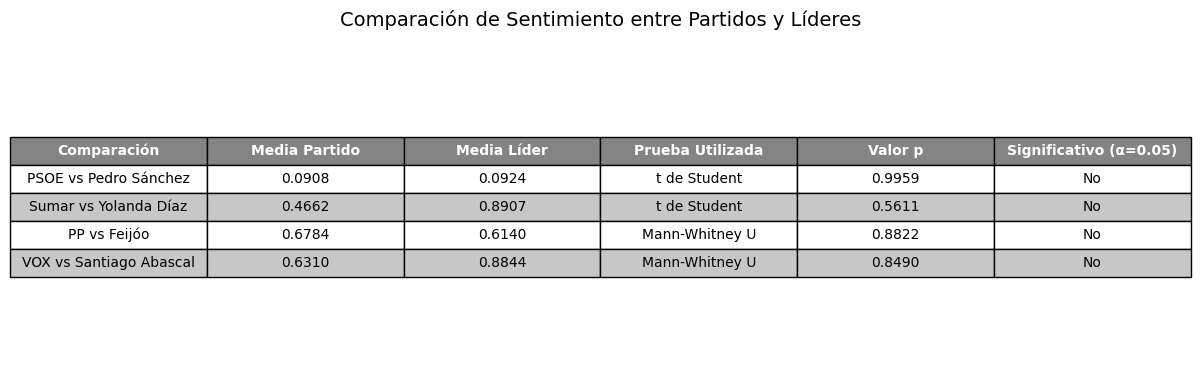

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Después de crear el DataFrame df_resultados como antes
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
ax.axis('tight')

# Crear tabla con matplotlib
tabla = ax.table(
    cellText=df_resultados.values,
    colLabels=df_resultados.columns,
    loc='center',
    cellLoc='center'
)

# Ajustar tamaño de la tabla
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.5)

# Colorear encabezados
for i, key in enumerate(df_resultados.columns):
    tabla[(0, i)].set_facecolor("#858484")
    tabla[(0, i)].set_text_props(color='white', fontweight='bold')

# Colorear filas alternas
for i in range(1, len(df_resultados) + 1):
    if i % 2 == 0:
        for j in range(len(df_resultados.columns)):
            tabla[(i, j)].set_facecolor("#C7C7C7")

plt.title('Comparación de Sentimiento entre Partidos y Líderes', fontsize=14)
plt.tight_layout()
plt.savefig('tabla_resultados.png', dpi=300, bbox_inches='tight')
plt.show()

Boxplot

Matplotlib is building the font cache; this may take a moment.


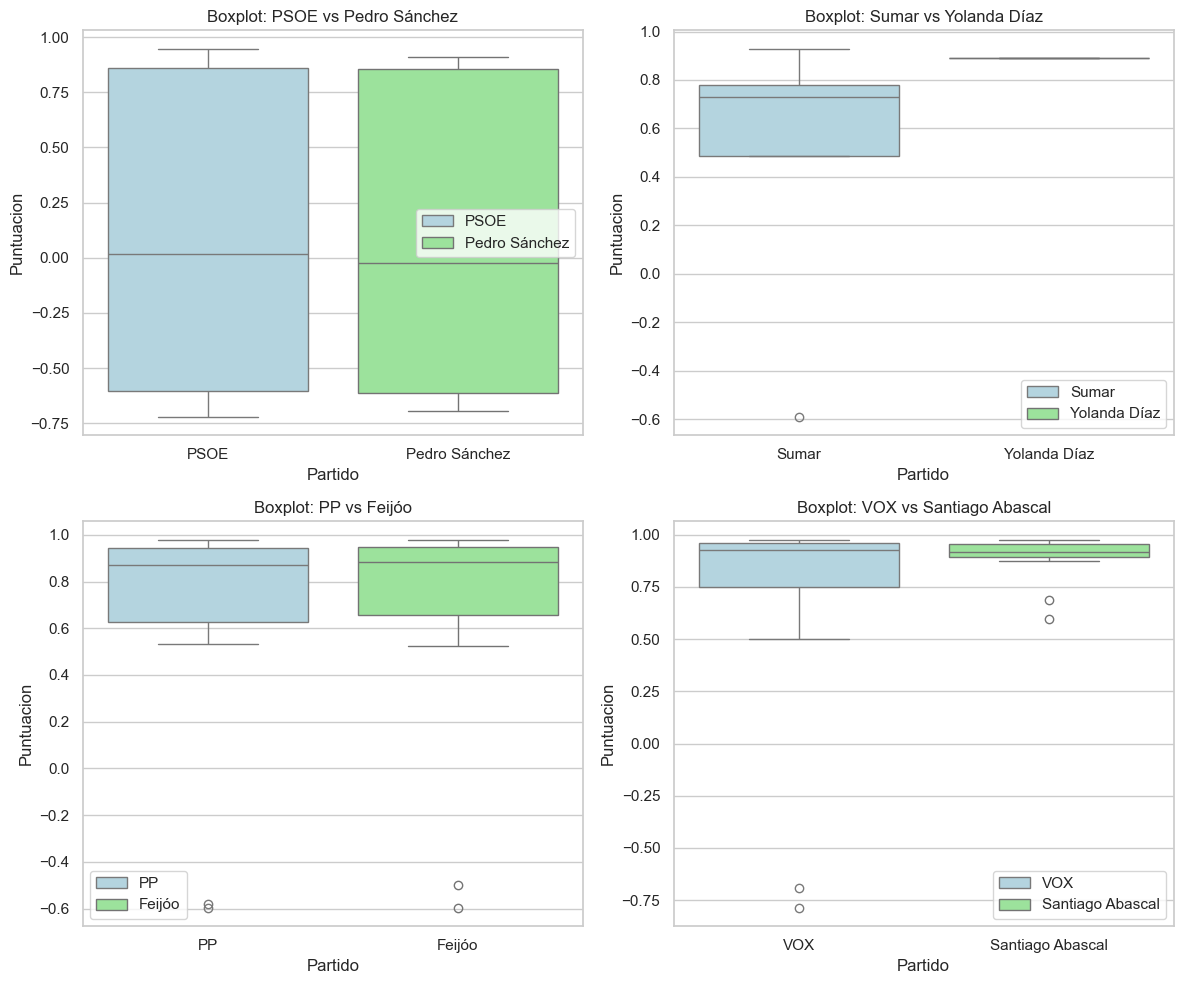

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar estilo de los gráficos
sns.set_theme(style="whitegrid")

# Crear figura con 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. PSOE vs Pedro Sánchez
sns.boxplot(data=data_psoe, x="Partido", y="Puntuacion", ax=axs[0, 0], color="lightblue", label="PSOE")
sns.boxplot(data=data_ps, x="nombre", y="Puntuacion", ax=axs[0, 0], color="lightgreen", label="Pedro Sánchez")
axs[0, 0].set_title("Boxplot: PSOE vs Pedro Sánchez")
axs[0, 0].legend()

# 2. Sumar vs Yolanda Díaz
sns.boxplot(data=data_su, x="Partido", y="Puntuacion", ax=axs[0, 1], color="lightblue", label="Sumar")
sns.boxplot(data=data_yd, x="nombre", y="Puntuacion", ax=axs[0, 1], color="lightgreen", label="Yolanda Díaz")
axs[0, 1].set_title("Boxplot: Sumar vs Yolanda Díaz")
axs[0, 1].legend()

# 3. PP vs Feijóo
sns.boxplot(data=data_pp, x="Partido", y="Puntuacion", ax=axs[1, 0], color="lightblue", label="PP")
sns.boxplot(data=data_nf, x="nombre", y="Puntuacion", ax=axs[1, 0], color="lightgreen", label="Feijóo")
axs[1, 0].set_title("Boxplot: PP vs Feijóo")
axs[1, 0].legend()

# 4. VOX vs Santiago Abascal
sns.boxplot(data=data_vox, x="Partido", y="Puntuacion", ax=axs[1, 1], color="lightblue", label="VOX")
sns.boxplot(data=data_ab, x="nombre", y="Puntuacion", ax=axs[1, 1], color="lightgreen", label="Santiago Abascal")
axs[1, 1].set_title("Boxplot: VOX vs Santiago Abascal")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

Histograma para ver la distribución 

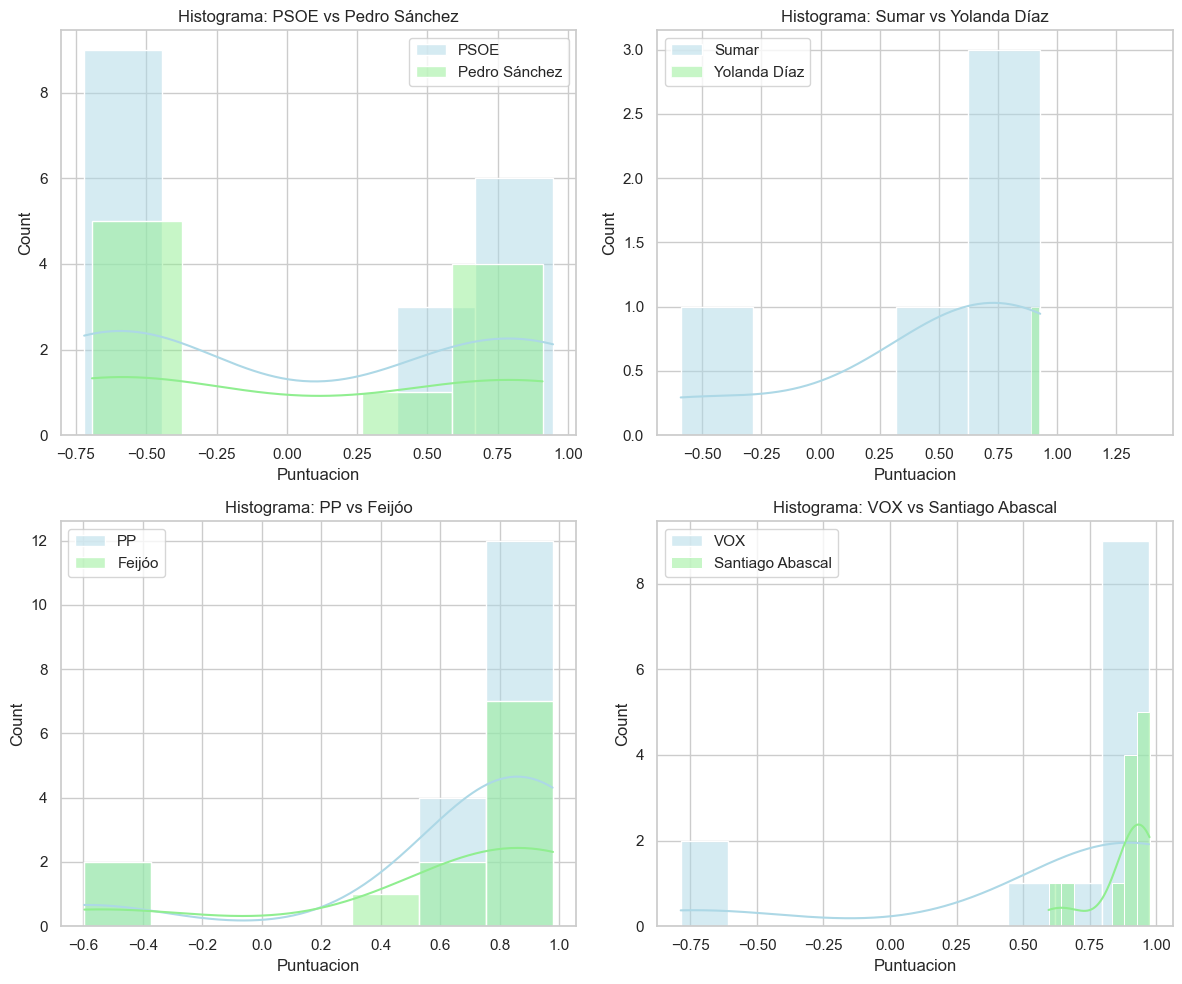

In [15]:
# Configurar estilo de los gráficos
sns.set_theme(style="whitegrid")

# Crear figura con 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. PSOE vs Pedro Sánchez
sns.histplot(data=data_psoe, x="Puntuacion", ax=axs[0, 0], color="lightblue", label="PSOE", kde=True)
sns.histplot(data=data_ps, x="Puntuacion", ax=axs[0, 0], color="lightgreen", label="Pedro Sánchez", kde=True)
axs[0, 0].set_title("Histograma: PSOE vs Pedro Sánchez")
axs[0, 0].legend()

# 2. Sumar vs Yolanda Díaz
sns.histplot(data=data_su, x="Puntuacion", ax=axs[0, 1], color="lightblue", label="Sumar", kde=True)
sns.histplot(data=data_yd, x="Puntuacion", ax=axs[0, 1], color="lightgreen", label="Yolanda Díaz", kde=True, bins=30)
axs[0, 1].set_title("Histograma: Sumar vs Yolanda Díaz")
axs[0, 1].legend()

# 3. PP vs Feijóo
sns.histplot(data=data_pp, x="Puntuacion", ax=axs[1, 0], color="lightblue", label="PP", kde=True)
sns.histplot(data=data_nf, x="Puntuacion", ax=axs[1, 0], color="lightgreen", label="Feijóo", kde=True)
axs[1, 0].set_title("Histograma: PP vs Feijóo")
axs[1, 0].legend()

# 4. VOX vs Santiago Abascal
sns.histplot(data=data_vox, x="Puntuacion", ax=axs[1, 1], color="lightblue", label="VOX", kde=True)
sns.histplot(data=data_ab, x="Puntuacion", ax=axs[1, 1], color="lightgreen", label="Santiago Abascal", kde=True)
axs[1, 1].set_title("Histograma: VOX vs Santiago Abascal")
axs[1, 1].legend()

plt.tight_layout()
plt.show()
